# MLP Pytorch Tutorial


---
### Introduction ###
In this exercise, you will classify Fisher's `Iris` dataset by using Pytorch. This dataset data set is a multivariate data set introduced by the British statistician and biologist Ronald Fisher in his 1936 paper.

The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters.

--- 
### Importing various libraries 

We import `DataLoader` here. By using the `DataLoader` library, we can easily shuffles our data and loads data in batches according to the `batch_size` you specified.
~~~ python
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
~~~

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader

### Load Data

In [0]:
# Authenticate and create the PyDrive client.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
import pandas as pd
link_iris = 'https://drive.google.com/open?id=1LP7W5xCIFuoi6kUHDNzMUbYr57Efrnf_'
fluff, id = link_iris.split('=')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Iris.csv')
iris_df = pd.read_csv('Iris.csv')

### DataLoader
1. Split the dataset into training and test dataset

2. Make custom `Dataset`


In [0]:
from sklearn.model_selection import train_test_split

iris_df['label'] = iris_df['species'].astype('category').cat.codes
iris_df.drop(['species'], axis=1, inplace=True)
train_df, test_df = train_test_split(iris_df, test_size=0.3, random_state=1)

In [0]:
X_train = torch.tensor(train_df.drop(['label'], axis=1).values, dtype=torch.float32)
Y_train = torch.tensor(train_df['label'].values, dtype=torch.long)
X_test = torch.tensor(test_df.drop(['label'], axis=1).values, dtype=torch.float32)
Y_test = torch.tensor(test_df['label'].values, dtype=torch.long)

In [0]:
class CustomDataset(Dataset):
    def __init__(self, x_data, y_data):
        assert(len(x_data) == len(y_data))
        self.x_data = x_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return len(self.x_data)
      
train_dataset = CustomDataset(X_train, Y_train)
test_dataset = CustomDataset(X_test, Y_test)

3. Define `loader_train` and `loader_test` to load the dataset.
~~~ python
batch_size = 4
loader_train = DataLoader(train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(test, batch_size=batch_size, shuffle=True)
~~~

In [0]:
batch_size = 4
loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

---
### Model

We introduce a sample model for you. 

* Sample Model
    * Linear layer (input: 4, output: 5)
    * Sigmoid activation function
    * Linear layer (input: 5, output: 3)
    * Cross Entropy Loss function
    
The first `Linear layer` has `input: 4` because of 4 input features. The second `Linear layer` has `output: 3` because Fisher's `Iris` dataset has 3 classes.

Implement the following pytorch neural network model.

~~~ python
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear = torch.nn.Linear(4, 5)
        self.linear2 = torch.nn.Linear(5, 3)
        self.activ = torch.nn.Sigmoid()

    def forward(self, x):
        return self.linear2(self.activ(self.linear(x)))
    
model = Model()
~~~

or

~~~ python
model = torch.nn.Sequential(
    torch.nn.Linear(4, 5),
    torch.nn.Sigmoid(),
    torch.nn.Linear(5, 3)
)
~~~

In [0]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear = torch.nn.Linear(4, 5)
        self.linear2 = torch.nn.Linear(5, 3)
        self.activ = torch.nn.Sigmoid()

    def forward(self, x):
        return self.linear2(self.activ(self.linear(x)))
    
model = Model()

In [0]:
model = torch.nn.Sequential(
    torch.nn.Linear(4, 5),
    torch.nn.Sigmoid(),
    torch.nn.Linear(5, 3)
)


---
### Cost Function and Optimizer

As mentioned, you use `CrossEntropyLoss` for cost function(lossfn), and use `SGD` for optimizer.

~~~ python
lossfn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
~~~

In [0]:
# Practice Here!
lossfn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

---
### Training

The training process is as follows:

* For each epoch
    * For each batch
        1. Calculate score from your model
        2. Calculate loss with loss function
        3. Initialize gradient of optimizer
        4. Do backward path with loss
        5. Step optimizer and update gradient

`cost` is used to store and visualize the losses that calculated in each batch. You iterate `loader_train` and access `coordiates` and `label`. The size of `coordinates` will be `(batch_size, 2)` because of x-coordinate and y-coordinate, and the size of `label` will be `(batch_size)`.
~~~ python
cost = []
def train(model, loader_train, loss_fn, optimizer, num_epochs=1):
    for epoch in range(num_epochs):
        for coordinates, label in loader_train:
            # 1. Calculate score from your model
            label_hat = model(coordinates)
            # 2. Calculate loss with loss function
            loss = lossfn(label_hat, label)
            # 3. Initialize gradient of optimizer
            optimizer.zero_grad()
            # 4. Do backward path with loss
            loss.backward()
            # 5. Step optimizer and update gradient
            optimizer.step()
            
            cost.append(loss)
        if (epoch + 1) % (num_epochs / 10) == 0:
            print('Epoch = %d, loss = %.4f' % (epoch + 1, cost[-1]))
~~~

In [0]:
cost = []
def train(model, loader_train, loss_fn, optimizer, num_epochs=1):
    for epoch in range(num_epochs):
        for coordinates, label in loader_train:
            label_hat = model(coordinates)
            loss = lossfn(label_hat, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            cost.append(loss)
        if (epoch + 1) % (num_epochs / 10) == 0:
            print('Epoch = %d, loss = %.4f' % (epoch + 1, cost[-1]))

---
### Test your Result ###

Check your implementation with this code. You should see the cost(loss) is decreasing and the test result is well classified about `97%` accuracy.
~~~ python
def check_accuracy(model, loader_test):
    num_correct = 0
    num_samples = 0
    model.eval()
    for x, y in loader_test:
        scores = model(x)
        _, preds = scores.max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

train(model, loader_train, lossfn, optimizer, num_epochs=400)
check_accuracy(model, loader_test)
plt.plot(cost)
plt.show()
~~~

Epoch = 40, loss = 1.0137
Epoch = 80, loss = 0.5052
Epoch = 120, loss = 0.4910
Epoch = 160, loss = 0.2551
Epoch = 200, loss = 0.5557
Epoch = 240, loss = 0.0621
Epoch = 280, loss = 0.1425
Epoch = 320, loss = 1.7155
Epoch = 360, loss = 0.0339
Epoch = 400, loss = 0.0837
Got 44 / 45 correct (97.78)


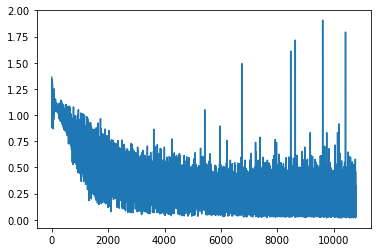

In [83]:
def check_accuracy(model, loader_test):
    num_correct = 0
    num_samples = 0
    model.eval()
    for x, y in loader_test:
        scores = model(x)
        _, preds = scores.max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

train(model, loader_train, lossfn, optimizer, num_epochs=400)
check_accuracy(model, loader_test)
plt.plot(cost)
plt.show()